# About

This is a copy of the other for analsysis puposed and is a partial rewrite.
It does not fix the XChem codes within hits (`ref_mols` in Fragalysis specs)

In previous version FPs were compared. This version to make things easier on the exports ichi keys are.
These are stripped of chirality to make life easier.

# Global variables

In [ ]:
asap_project_id = 'ASAP-EVD68-3CLPRO'
xchem_project_id = 'D68EV3CPROA'
metadata_filename = 'D68EV3CPROA_metadata.csv'

# column names as will be used for upload

labels = {'SMILES': 'SMILES',
         'XChem code': f'fragment_XChem-code',
         'method': 'fragment_method-name',
         'notes': 'fragment_notes',
         'keywords': 'fragment_method-keywords',
         'date': f'fragment_method-date',
         'institution': f'fragment_submitter_institution',
         'name': f'fragment_submitter_name',
         'email': f'fragment_submitter_email',
         'ref XChem': f'fragment_reference_XChem',
         'ref vcid': f'fragment_reference_vcid',
         'ref SMILES': f'fragment_reference_SMILES',
          'rationale': 'fagment_rationale',
         }

# Import D68EV3CPROA_metadata.csv

In [125]:
import pandas as pd
import pandera.typing as pdt
from pathlib import Path
import functools
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, DataStructs
from typing import List
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit import rdBase


def to_bad_inchi(smiles):
    """
    Inchi with no chirality (bad)
    """
    mol: Chem.Mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ''
    mol = SaltRemover().StripMol(mol)
    Chem.RemoveStereochemistry(mol)
    mol = AllChem.RemoveAllHs(mol)
    return Chem.MolToInchi(mol)
    
    
from typing import Set, Sequence
import pandas as pd

def dodgy_type_fix(df: pd.DataFrame, protected: Sequence[str]=()) -> pd.DataFrame:
    """
    Fix the types assuming nans happened.
    """
    df = df.copy()
    for k in df.columns:
        types: Set[type] = set(df[k].apply(type).to_list())
        if k in protected:
            pass # protected. Skip!
        elif len(types) == 1:
            df[k] = df[k].astype(types.pop())
        elif float in types and str in types:
            df[k] = df[k].fillna('').astype(str)
        elif float in types and int in types:
            df[k] = df[k].fillna(-1).astype(int)
        elif float in types:
            other: type = (types - {float}).pop()
            df[k] = df[k].apply(lambda v: v if not isinstance(v, float) else other()).astype(other)
        else:
            print(f'Not altered {k} ({types}). no ideal what is wrong.')
            pass
    return df.copy()


# ------------------------------------------------------------

metadata = pd.read_csv('D68EV3CPROA_metadata.csv')
metadata['name'] = metadata.RealCrystalName.str.replace(f'{xchem_project_id}-', '')
# for some reason the alt ids went from Enamine to ASAP Reg IDs
originals: List[str] = metadata.loc[~metadata.alternate_name.str.contains('ASAP')].RealCrystalName.to_list()

with rdBase.BlockLogs() as blocker:
    metadata['simple_inchi'] = metadata.new_smiles.apply(to_bad_inchi)

# Library

In [130]:
import pandas as pd

libraries = pd.read_csv('https://github.com/matteoferla/Fragment-hit-follow-up-chemistry/raw/main/combined-XChem-libraries.csv', index_col=0)
reduced_libraries  =  libraries.drop_duplicates(['SMILES', 'library']) \
                     .groupby('SMILES').agg({'library': ','.join, 
                                             'Id':set }) \
                     .reset_index()
reduced_libraries['Id'] = reduced_libraries['Id'].apply(','.join)

with rdBase.BlockLogs() as blocker:
    reduced_libraries['simple_inchi'] = reduced_libraries.SMILES.apply(to_bad_inchi)

## ASAP data

In [132]:
asapt: pd.DataFrame = dodgy_type_fix( pd.read_csv('project-ASAPPSOTNS.csv') )

with rdBase.BlockLogs() as blocker:
    asapt['simple_inchi']: pdt.Series[str] = asapt.original_query.apply(to_inchi)
    
asapt['is_XChem'] = asapt.designer_institution == 'XChem'
asapt = asapt.sort_values('is_XChem', ascending=False).reset_index(drop=True)

/var/folders/70/28pvwk5s63q9xd4mwxj039hm0000gp/T/ipykernel_92014/456933751.py:1: DtypeWarning: Columns (17,18,20,21,28,32,33,35,41,42,43,44,45,46,47,48,49,53,54,55,56,58,59,60,64,66,67,69,70,73,92,93,95,98,102,103,108,111,112,125,127,128,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,154,155,156,158,159,160,161,162,163,164,167,168,175,176,177,178,180,181,182,183,184,187,188,189,190,197,198,199,200,203,204,205,206,207,208,209,214,215,216,217,222,231,232,233,234,235,236,237,239,240,241,242,243,245,246,247,248,249,250,255,256,260,261,262,263,264,267,271,274,276,277,279,282,283,284,285,287,292,297,300,302,303,306,307,310,311,314,315,322,326,327,328,329,330,333,339,340,343,344,345) have mixed types. Specify dtype option on import or set low_memory=False.
  asapt: pd.DataFrame = dodgy_type_fix( pd.read_csv('project-ASAPPSOTNS.csv') )


# CSets
From Fragalysis

In [163]:
from rdkit import Chem
from pathlib import Path
import requests
import pandas as pd
import operator, os


def retrieve(sdf_url, folder=Path('media_compound-sets')):
    if not sdf_url:
        return ''
    name = folder / Path(sdf_url).parts[-1]
    if Path(name).exists():
        return str(name)
    try:
        response: requests.Response = requests.get(sdf_url)
        response.raise_for_status()
        with open(name, 'w') as fh:
            fh.write( response.text )
        return str(name)
    except requests.HTTPError as error:
        print(error.__class__.__name__, str(error))
        return ''

csets = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/compound-sets/').json()['results'] )
targets = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/targets/').json()['results'] )
id2name = targets.set_index('id').title.to_dict()
csets['target_name'] = csets.target.map(id2name)
csets['sdf_name'] = csets.submitted_sdf.apply(lambda v:os.path.split(v)[-1] if v else '')
filenames: pd.Series = csets.loc[csets.target_name == xchem_project_id].submitted_sdf.apply(retrieve)
assert (filenames != '').any(), 'Fragalysis route is stil broken'

HTTPError 404 Client Error: Not Found for url: https://fragalysis.diamond.ac.uk/media/code/media/compound_sets/compound-set_fragnetv1_sujHlIc.sdf


# CSet from passed files

Ref IDs not fixed in this version!

In [164]:
len(filenames)

14

In [298]:
vcs = []
header = Chem.Mol
filename: str
for filename in filenames.to_list():
    if filename == '':
        continue
    name = filename.split('.')[0]
    if os.path.getsize(filename) == 0:
        print(f'Empty {filename}')
        continue
    print(filename)
    with Chem.SDMolSupplier(filename) as sdfh:
        for vc in sdfh:
            if vc.GetProp('_Name') == 'ver_1.2':
                header = vc
                continue
            vc.SetProp('dataset_filename', name)
            vc.SetProp(labels['method'], header.GetProp('method'))
            vc.SetProp(labels['name'], header.GetProp('submitter_name'))
            vc.SetProp(labels['email'], header.GetProp('submitter_email'))
            vc.SetProp(labels['institution'], header.GetProp('submitter_institution'))
            vc.SetProp(labels['date'], header.GetProp('generation_date'))
            vcs.append(vc)
        del header

print(f'N VCs {len(vcs)}')

media_compound-sets/compound-set_fragnetv2_named2.sdf
media_compound-sets/compound-set_fragnetv3_corrected_Yg1WEd6.sdf
media_compound-sets/rocs_EV-D68_3C_cfWeZxn.sdf
media_compound-sets/compound-set_STRIFEx1083_kjmiwFa.sdf
media_compound-sets/Teo-submissions_EV-D68_3C_LLQgF2R.sdf
media_compound-sets/Arthor-sulfonamide_EV-D68_3C_SroVYeD.sdf
media_compound-sets/Fragmenstein-Tris_C8PbTBl.sdf
media_compound-sets/Fragmenstein-Tris_P1-ridge.sdf
media_compound-sets/compound-set_fragNetMergingIt3_3yGitfX.sdf
media_compound-sets/ROCS-S2_EV-D68_3C_xNia8MG.sdf
media_compound-sets/LucyVost-STRIFEfollowups_ApSdXBM.sdf
N VCs 1047


# Convert

In [299]:
from typing import Dict
import yaml

fragalysis2postera_yaml = \
'''
ref_url: design_submission_source_link
submitter_email: designer_email
# made up
submitter_name: designer_name
submitter_institution: designer_institution
generation_date: design_date
method: design_notes
# not matched to Fragalysis header
# related_molecules
'''

# made up: for each hit
# design_reference_hits: ref_mols
# design_rationale Computational follow-ups as part of Project 2.

fragalysis2postera: Dict[str, str] = yaml.load(fragalysis2postera_yaml, Loader=yaml.FullLoader)

In [302]:
from rdkit import Chem
from rdkit.Chem import AllChem
    
import re
for vc in vcs:
    if vc.HasProp('ref_mols'):
        ref_mols = ','.join(re.findall(r'(x\w+_\w+)',  vc.GetProp('ref_mols') ))
    else:
        ref_mols = ''
    vc.SetProp('ref_mols', ref_mols)
        
#header_info = header.GetPropsAsDict()

def get_catalogue(name):
    if 'Z' in name:
        return name.split('-')[0]
    elif 'PV' in name:
        return 'PV-' + name.split('-')[1]
    elif 'EN300' in name:
        return 'EN300-' + name.split('-')[1]
    else:
        return ''
        #raise ValueError


submissions = pd.DataFrame([vc.GetPropsAsDict() for vc in vcs])

# for col_fragalysis, col_post in fragalysis2postera.items():
#     submissions[col_post] = header.GetProp(col_fragalysis)
    
with rdBase.BlockLogs() as blocker:
    submissions['simple_inchi'] = submissions['original SMILES'].apply(to_bad_inchi)

# Combine

In [314]:
m1 = pd.merge(metadata, submissions, on='simple_inchi', how='left')
m2 = pd.merge(m1, reduced_libraries, on='simple_inchi', how='left')
merged = pd.merge(m2, asapt, on='simple_inchi', how='left')
del m1
del m2

In [315]:
merged.design_id_postera.value_counts()

design_id_postera
ASAP-DESIGN-995    189
ASAP-DESIGN-996    189
ASAP-DESIGN-987    177
ASAP-DESIGN-663     20
ASAP-DESIGN-990     14
ASAP-DESIGN-673      7
ASAP-DESIGN-552      5
ASAP-DESIGN-527      4
ASAP-DESIGN-610      4
ASAP-DESIGN-785      3
ASAP-DESIGN-780      3
ASAP-DESIGN-666      2
ASAP-DESIGN-528      1
ASAP-DESIGN-579      1
ASAP-DESIGN-619      1
ASAP-DESIGN-508      1
ASAP-DESIGN-642      1
ASAP-DESIGN-634      1
ASAP-DESIGN-526      1
ASAP-DESIGN-709      1
Name: count, dtype: int64

In [331]:
def classify(group):
    if isinstance(group, float):
        return 'Unknown'
    if group.strip() in ('Successful crystallised hits soaks Diamond DLS XChem initial fragment library', 
                         'Crystallised DLS XChem fragment screening soaks hits',
                         'Fragment screening libraries available at DLS XChem'):
        return 'library'
    if group.strip() in ('Computational follow-ups as part of Project 2.',
                                          'Wave 2 designs: P2: computational follow-up: available in catalog',
                                         "2nd wave of computational follow-up using \nFragmenstein => https://github.com/matteoferla/Fragmenstein\nSteph's graph enumeration approach => https://pubmed.ncbi.nlm.nih.gov/37229647/ or https://www.biorxiv.org/content/10.1101/2022.12.15.520559v1\nLucy's STRIFE\nSanity checked by Ed Griffen and Tryfon"):
        return 'OPIG'
    return 'Postera'

merged['group'] = merged.design_rationale.apply(classify)

In [317]:
#'fragment_XChem_code', 'fragment_submitter_name','fragment_method_name', 

In [332]:
merged.loc[merged.group == 'OPIG']\
        [['name', 'design_rationale', 'fragment_submitter_name_x', 'fragment_method-name']].drop_duplicates('name')

,name,design_rationale,fragment_submitter_name_x,fragment_method-name
573,x2135,Computational follow-ups as part of Project 2.,Matteo Ferla,ROCS & PyRosetta-filtering
582,x2148,Computational follow-ups as part of Project 2.,Matteo Ferla,Manual-Submission
585,x2149,Computational follow-ups as part of Project 2.,Matteo Ferla,Manual-Submission
598,x2495,Computational follow-ups as part of Project 2.,Matteo Ferla,Manual-Submission


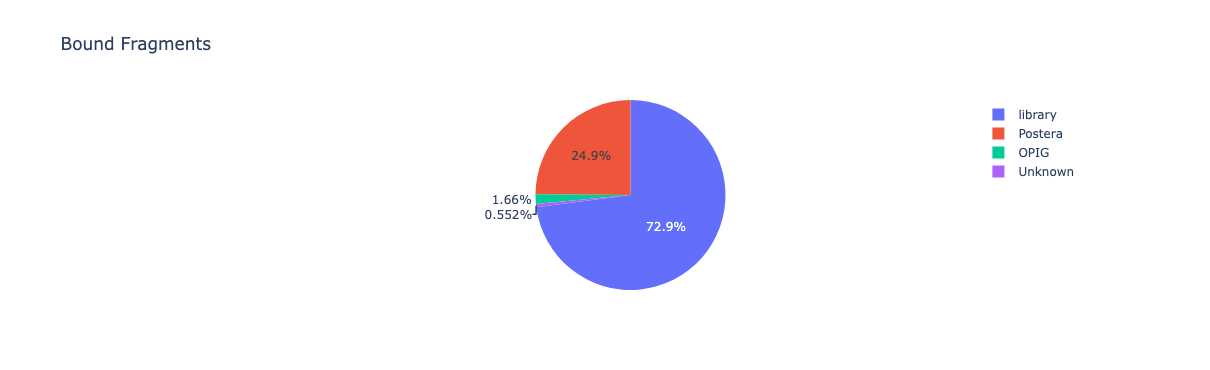

In [337]:
import plotly.express as px

px.pie(merged.drop_duplicates('crystal_name'), 'group', title='Bound Fragments')

In [339]:
merged.loc[merged.group == 'Unknown']

,Unnamed: 0,crystal_name,RealCrystalName,smiles_x,new_smiles,alternate_name,site_name,pdb_entry,name,simple_inchi,...,mcule_postera.1,molport_postera.1,pubchem_postera.1,sigma_postera.1,surechembl_postera.1,wuxi_postera.1,reg_id_postera,vc_id_postera,is_XChem,group
625,180,D68EV3CPROA-x2737_0A,D68EV3CPROA-x2737,CCC(=O)N(c1ccc(F)c(C(F)(F)F)n1)[C@H]3Cc2ccccc2...,CCC(=O)N(c1ccc(F)c(C(F)(F)F)n1)[C@H]3Cc2ccccc2...,ASAP-0014865-001,follow-up,NaN,x2737,InChI=1S/C18H15F4N3O2/c1-2-15(26)25(14-8-7-11(...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
